In [25]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import itertools
%matplotlib inline

In [320]:
df = pd.read_csv('credit_card_default_analysis.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Задание 1

Для начала, посмотрим на данные и на то, как распределены LIMIT_BAL у тех, кто вернул и не вернул кредит 

In [321]:
limit_bal_0 = df[df['default'] == 0]['LIMIT_BAL']
limit_bal_1 = df[df['default'] == 1]['LIMIT_BAL']

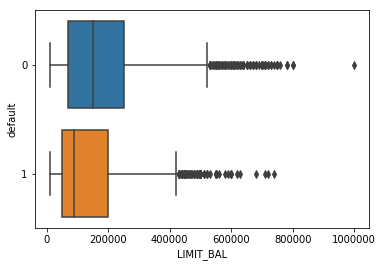

In [322]:
sns.boxplot(x=df['LIMIT_BAL'], y=df['default'], orient='h');

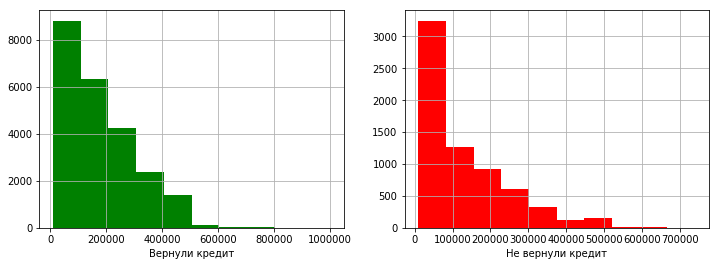

In [323]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.grid()
plt.hist(limit_bal_0, color='green')
plt.xlabel(u'Вернули кредит')

plt.subplot(1,2,2)
plt.grid()
plt.hist(limit_bal_1, color='red')
plt.xlabel(u'Не вернули кредит')

plt.show()

### a) Проверяем гипотезу о равенстве медианных значений кредитного лимита

* H0 - медианные значения кредитного лимита равны
* H1 - медианные значения кредитного лимита отличаются

In [324]:
print u'Медианы - {} и {} соответственно'.format(limit_bal_0.median(), limit_bal_1.median())

Медианы - 150000.0 и 90000.0 соответственно


####  Сравним медианы методом Bootstrap



In [325]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [326]:
lb_0_bootstraped_median = np.median(get_bootstrap_samples(limit_bal_0.values, 1000), axis=1)
lb_1_bootstraped_median = np.median(get_bootstrap_samples(limit_bal_1.values, 1000), axis=1)

Посчитаем доверительный интервал 2-х получившихся величин для Alpha=0.05. Если 0 в него не входит, зачит мы с уверенностью можем сказать, что выборки значимо отличаются

In [327]:
lb_confint = stat_intervals(lb_0_bootstraped_median - lb_1_bootstraped_median, 0.05)
print u'Доверительный интервал: {} - {}'.format(lb_confint[0], lb_confint[1])

Доверительный интервал: 60000.0 - 70000.0


Нулевую гипотезу о том, что медианы размера кредитного лимита вернувших и не вернувших кредит равны, мы можем смело отвергнуть в пользу двусторонней альтернативы, т.к. 0 не попадает в доверительный интервал разности медиан.

### б) Проверяем гипотезу о равенстве распределений

Для проверки гипотезы о равенстве распределений будем использовать непараметрический перестановочный критерий. Так как выборки независимые, будем использовать перестановочный критерий для 2-х независимых выборок.

* H0 - распределения одинаковы
* H1 - распределения отличаются

Достигаемый уровень значимости - 0.05

In [328]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [330]:
pvalue_limit_bal = permutation_test(limit_bal_0, limit_bal_1, max_permutations=5000)

In [331]:
pvalue_limit_bal

0.0002

Так как pvalue = 0.0002, что значительно < 0.05, нулевую гипотезу о равенстве распределений мы отвергаем в пользу двусторонней альтернативы

### Практическая значимость

Логично, что кредитный лимит меньше у тех, кто не возвращает кредиты, результат можно считать практически значимым

## Задание 2

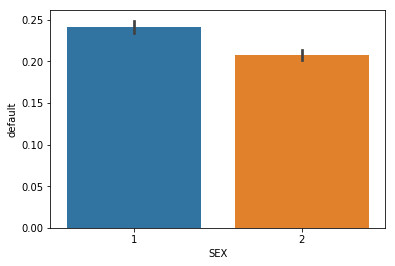

In [120]:
sns.barplot(x='SEX', y='default', data=df);

Приводим значения признака "SEX" к бинарному виду

In [127]:
sex_0 = df[df['default'] == 0]['SEX'].replace(2, 0)
sex_1 = df[df['default'] == 1]['SEX'].replace(2, 0)

В выборках у нас только 2 значения: 1 и 0, а значит они взяты из распределения Бернулли и мы имеем право применять Z-критерий для доли или разности долей.

#### Проверяем гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается, с помощью доверительного интервала

* H0 - гендерный состав группы людей вернувших и не вернувших кредит одинаков
* H1 - гендерный состав группы людей вернувших и не вернувших кредит отличается

Достигаемый уровень значимости - 0.05

In [144]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [437]:
print 'Доверительный интервал для разности долей вернувших и не вернувших кредиты:'
proportions_confint_diff_ind(sex_1, sex_0, alpha=0.05)

Доверительный интервал для разности долей вернувших и не вернувших кредиты:


(0.03363493274962867, 0.060548077974896725)

Т.к. доверительные интервал не включает в себя 0, то H0 отвергается в пользу двусторонней альтернативы H1, говорящей, что гендерный состав группы людей вернувших и не вернувших кредит отличается

#### Проверяем гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается, с Z-критерия для разности долей независимых выборок

* H0 - гендерный состав группы людей вернувших и не вернувших кредит одинаков
* H1 - гендерный состав группы людей вернувших и не вернувших кредит отличается

Достигаемый уровень значимости - 0.05

In [147]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [158]:
sex_z = proportions_diff_z_stat_ind(sex_0, sex_1)
print 'p-value: {}'.format( 2 * (1 - stats.norm.cdf(np.abs(sex_z))))

p-value: 4.47286652161e-12


Т.к. p-value значительно меньше достигаемого уровня значимости, мы уверенно отвергаем нулевую гипотезу и уже 2-й раз принимаем двустороннюю альтернативу H1, говорящую, что гендерный состав группы людей вернувших и не вернувших кредит отличается

## Задание 3

Посмотрим на данные

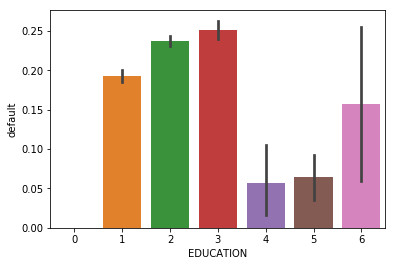

In [311]:
sns.barplot(x='EDUCATION', y='default', data=df);

In [175]:
edu0 = df[df['default'] == 0]['EDUCATION']
edu1 = df[df['default'] == 1]['EDUCATION']

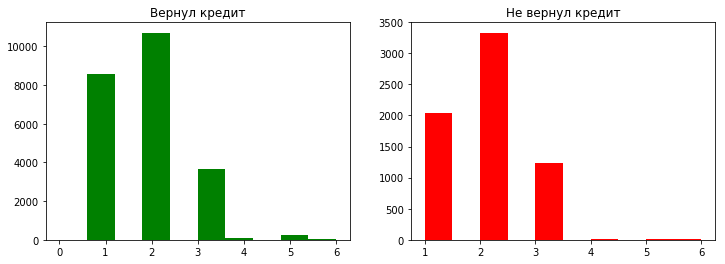

In [333]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(edu0, color='green')
plt.title(u'Вернул кредит')
plt.subplot(1,2,2)
plt.hist(edu1, color='red')
plt.title(u'Не вернул кредит')
plt.show()

In [305]:
edu_real_0 = df[df['default'] == 0][['EDUCATION', 'default']].groupby(['EDUCATION']).count()
edu_real_1 = df[df['default'] == 1][['EDUCATION', 'default']].groupby(['EDUCATION']).count()

Построим таблицу сопряженности реальных значений, ожидаемых значений и нормированной разницы этих значений

In [306]:
edu_crosstab = pd.crosstab(df['default'],df['EDUCATION'])
edu_crosstab

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,14,8549,10700,3680,116,262,43
1,0,2036,3330,1237,7,18,8


Ожидаемые значения получаем, если перераспределяем равномерно долю дефолта для всех значений EDUCATION. Т.е. для каждого типа образования соотношение default == 0 / default == 1 делаем одинаковым. То же самое значение можно было получить с помощью stats.chi2_contingency, но, по мне, так нагляднее.

In [307]:
coef_default = df['default'].sum() / float(df.shape[0])
edu_expected = edu_crosstab.apply(lambda col: [col.sum() - col.sum() * coef_default, col.sum() * coef_default], axis=0)
edu_expected

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,10.9032,8243.598,10926.564,3829.3596,95.7924,218.064,39.7188
1,3.0968,2341.402,3103.436,1087.6404,27.2076,61.936,11.2812


Чтобы нормировать таблицу, отнимем от реальных значений ожидаемые и поделим на ожидаемые. Теперь значение каждой ячейки - относительное отклонение реальных значений от ожидаемых. Это сделано, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости

In [308]:
(edu_crosstab - edu_expected) / edu_expected

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,0.284027,0.037047,-0.020735,-0.039004,0.210952,0.201482,0.082611
1,-1.000000,-0.130436,0.073004,0.137324,-0.742719,-0.709377,-0.290856


Теперь применим критерий Хи2, чтобы проверить гипотезу равенства распределений: 

* H0 - реальное распределение значений образования не отличается от ожидаемого и образование не влияет на то, вернет ли человек долг
* H1 - реальное распределение значений образования все-таки отличается от ожидаемого и образование влияет на то, вернет ли человек долг

Достигаемый уровень значимости - 0.05

Для начала, проверим условия применимости критерия Хи^2: количество объектов выборки в каждом интервале должно превышать 5 как минимум для 80% ячеек

In [422]:
(edu_crosstab > 5).values.sum() / float(edu_crosstab.shape[0] * edu_crosstab.shape[1])

0.9285714285714286

Количество объектов выборки в каждом интервале превышает 5 для 92% ячеек. Критерий Хи^2 применим

In [413]:
print 'pvalue = {}'.format(stats.chi2_contingency(edu_crosstab)[1])

pvalue = 1.23326262454e-32


H0 отвергается в пользу двусторонней альтернативы, потому что pvalue значительно < 0.05. Это значит, что образование влияет на то, вернет ли человек долг

In [318]:
df[(df['EDUCATION'] == 1) | (df['EDUCATION'] == 2) | (df['EDUCATION'] == 3)].shape[0] / float(df.shape[0])

0.9844

Формально, вероятность вернуть долг выше всего для тех, у кого есть начальное образование (4). Этот вывод контринтуитивен, объем выборки с этими значениями < 2%, и поэтому этот вывод практически не значим.

Значения EDUCATION = 1,2 и 3 состовляют 98% всей выборки. Поэтому в разрезе практической значимости будем рассматривать именно их. Вероятность вернуть долг выше всего у обладателей магистрской степени (1) и ниже всего - для выпускника школы (1). Эти значения интуитивны, логичны и практически значимы.

## Задание 4

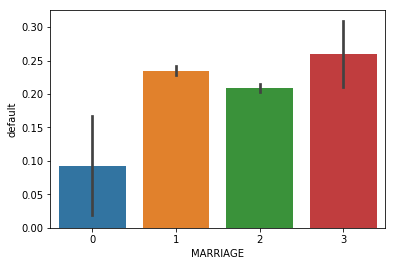

In [334]:
sns.barplot(x='MARRIAGE', y='default', data=df);

In [335]:
mar0 = df[df['default'] == 0]['MARRIAGE']
mar1 = df[df['default'] == 1]['MARRIAGE']

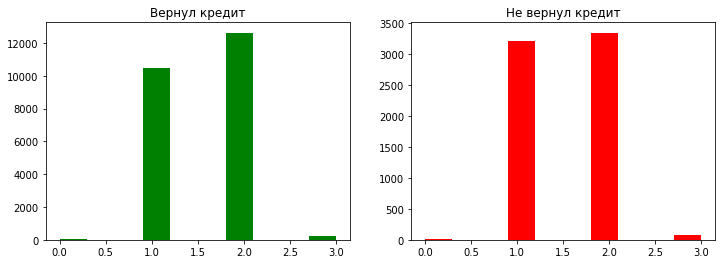

In [336]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(mar0, color='green')
plt.title(u'Вернул кредит')
plt.subplot(1,2,2)
plt.hist(mar1, color='red')
plt.title(u'Не вернул кредит')
plt.show()

In [337]:
mar_crosstab = pd.crosstab(df['default'],df['MARRIAGE'])
mar_crosstab

MARRIAGE,0,1,2,3
default,,,,
0,49,10453,12623,239
1,5,3206,3341,84


Так как у нас обе величины категориальны, для взаимосвязи между ними посчитаем коэффициент V Крамера.

Но прежде, чем это сделаем, проверим условия применимости критерия Хи^2, который нам понадобится для подсчета коэффициент Крамера: количество объектов выборки в каждом интервале должно превышать 5 как минимум для 80% ячеек

In [424]:
(mar_crosstab > 5).values.sum() / float(mar_crosstab.shape[0] * mar_crosstab.shape[1])

0.875

Количество объектов выборки в каждом интервале превышает 5 для 87% ячеек. Критерий Хи^2 применим

In [394]:
def cramers_v(sample_crosstab):
    chi2 = stats.chi2_contingency(sample_crosstab)[0]
    n = sample_crosstab.values.sum()
    k1 = sample_crosstab.shape[0]
    k2 = sample_crosstab.shape[1]
    return np.sqrt(chi2 / (n * (min([k1, k2]) - 1)))

In [395]:
mar_corr = cramers_v(mar_crosstab)
print u'Взаимосвязь между семейным статусом и индикатором дефолта (коэффициент V Крамера) = {}'.format(mar_corr)

Взаимосвязь между семейным статусом и индикатором дефолта (коэффициент V Крамера) = 0.0344782036628


Т.к. коэффициент Крамера изменяется в интервале от 0 до 1, а в нашем случае он равен 0.034, то можно сказать, что связь между семейным статусом и вероятностью дефолта очень незначительная

## Задание 5

In [425]:
age0 = df[df['default'] == 0]['AGE']
age1 = df[df['default'] == 1]['AGE']

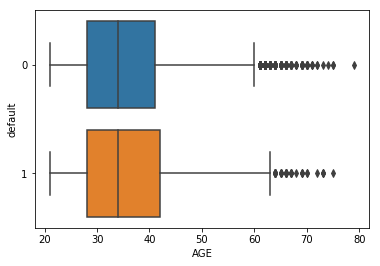

In [426]:
sns.boxplot(x=df['AGE'], y=df['default'], orient='h');

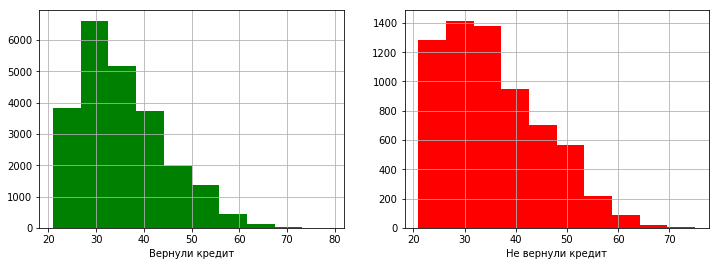

In [427]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.grid()
plt.hist(age0, color='green')
plt.xlabel(u'Вернули кредит')

plt.subplot(1,2,2)
plt.grid()
plt.hist(age1, color='red')
plt.xlabel(u'Не вернули кредит')

plt.show()

### a) Проверяем гипотезу о равенстве медианных значений возраста методом Bootstrap

* H0 - медианные значения возраста равны
* H1 - медианные значения возраста отличаются

Достигаемый уровень значимости - 0.05

In [428]:
age0_bootstraped_median = np.median(get_bootstrap_samples(age0.values, 1000), axis=1)
age1_bootstraped_median = np.median(get_bootstrap_samples(age1.values, 1000), axis=1)

In [431]:
age_confint = stat_intervals(age0_bootstraped_median - age1_bootstraped_median, 0.05)
print u'Доверительный интервал разности медиан возрастов: {} - {}'.format(age_confint[0], age_confint[1])

Доверительный интервал разности медиан возрастов: -1.0 - 0.0


Нулевую гипотезу о том, что медианы возраста вернувших и не вернувших кредит равны, мы отвергнуть не можем, потому что 0 попадает в наш доверительный интервал.

### б) Проверяем гипотезу о равенстве распределений


Для проверки гипотезы о равенстве распределений будем использовать непараметрический перестановочный критерий. Так как выборки независимые, будем использовать перестановочный критерий для 2-х независимых выборок.

* H0 - распределения одинаковы
* H1 - распределения отличаются

Достигаемый уровень значимости - 0.05

In [435]:
age_pvalue = permutation_test(age0, age1, max_permutations=5000)

In [436]:
age_pvalue

0.0166

Т.к. pvalue = 0.0166, что меньше 0.05, мы отвергаем нулевую гипотезу о равенстве распределений в пользу двусторонней альтернативы.

Полученные результаты как статистически, так и практической значимы.